In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import tensorflow as tf
import os
import copy
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing

In [2]:
import Onlinehd

In [3]:
def load_mnist():
    x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
    x = np.array(x).astype(np.float64)
    y = np.array(y).astype(np.int64)

    # Split
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y)

    x_train = x_train.reshape(-1, 28, 28)
    y_train = y_train.flatten()
    x_test = x_test.reshape(-1, 28, 28)
    y_test = y_test.flatten()

    return x_train, y_train, x_test, y_test

def load_emnist():
    temp = torchvision.datasets.EMNIST('./data/EMNIST', split = 'letters', train = True, download = True)
    x_train = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_train = temp.targets.numpy() - 1
    temp = torchvision.datasets.EMNIST('./data/EMNIST', split = 'letters', train = False, download = True)
    x_test = temp.data.unsqueeze(3).numpy().transpose((0,2,1,3))
    y_test = temp.targets.numpy() - 1

    return x_train, y_train, x_test, y_test

def load_fashion_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    return x_train, y_train, x_test, y_test

def load_data(dataset, save_data=True, use_new=False):
    if dataset.lower() == 'fmnist':
        x_train, y_train, x_test, y_test = load_fashion_mnist()
    elif dataset.lower() == 'emnist':
        x_train, y_train, x_test, y_test = load_emnist()
    elif dataset.lower() == 'mnist':
        x_train, y_train, x_test, y_test = load_mnist()
    else:
        print('Unknown dataset: {}'.format(dataset))
        raise AssertionError

    classes = np.unique([np.unique(y_train.flatten()), np.unique(y_test.flatten())])
    num_classes = len(classes)

    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
    x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

    x_train = torch.tensor(x_train)
    x_test = torch.tensor(x_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    return (x_train, y_train), (x_test, y_test), num_classes

In [4]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
(x_train, y_train), (x_test, y_test), num_classes = load_data('fmnist')
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_13140/3624615049.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_13140/3624615049.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [6]:
x = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)
x.shape

torch.Size([60000, 784])

In [7]:
y = train_labels
y_test = test_labels

In [8]:
x = x.float() 
y = y.long()
x_test = x_test.float() 
y_test = y_test.long()

In [9]:
print(x.shape)
print(y.shape)

torch.Size([60000, 784])
torch.Size([60000])


In [10]:
x_origin = x.clone()
x_test_origin = x_test.clone()
y_origin = y.clone()
y_test_origin = y_test.clone()

In [11]:
scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))

x = torch.tensor(scaler.transform(x.reshape(-1, 784)))
x_test = torch.tensor(scaler.transform(x_test.reshape(-1, 784)))

In [12]:
classes = y.unique().size(0)
features = x.size(1)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

In [13]:
def normalizer(x):
    x = np.array(x)
    max_value = np.max(x)
    min_value = np.min(x)
    return (x-min_value)/(max_value-min_value)

Text(0.5, 1.0, 'tensor(5)')

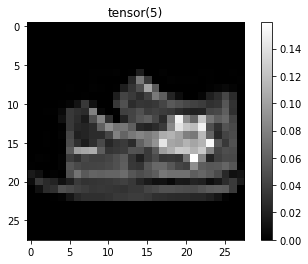

In [14]:
plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.title(y_test[-1])

In [15]:
model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)

0
10


In [16]:
from time import time

print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')

Validating...
acc = 0.833617
acc_test = 0.819600


In [37]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

is_cuda = torch.cuda.is_available()

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):  #num_classes; mnist:10/ fmnist:10 / emnist:26

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
   
    image = image
    model = net

    I = torch.argsort(-model.scores(image)).tolist()[0]  # sort image score (descending)
    label = I[0]  #label

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = model.scores(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = image.max().item()
#         pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.cpu().numpy().copy()

            # set new w_k and new f_k

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())
            
            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / (np.linalg.norm(w) + 0.001)
        r_tot = np.float32(r_tot + r_i)*3

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)
        
        x = Variable(pert_image, requires_grad=True)
        fs = model.scores(x)
        k_i = torch.argsort(-fs).tolist()[0][0]  # labels for x

        loop_i += 1

    #r_tot = (1+overshoot)*r_tot

    return pert_image, torch.from_numpy(r_tot.reshape(28, 28)) #loop_i, label, k_i,

In [38]:
X_te_cln = x_test.reshape(-1,1,784)  # x_test
Y_te_cln = y_test #y_test

In [44]:
from tqdm import tqdm

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(10000, 28, 28)

for i in tqdm(range(10000)):
    x_test_adv[i], x_test_pert[i] = deepfool(X_te_cln[i], model)

100%|█████████████████████████████████████| 10000/10000 [32:55<00:00,  5.06it/s]


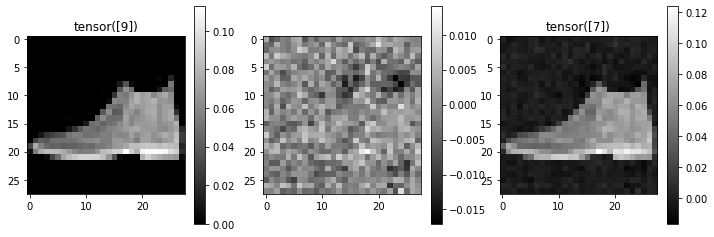

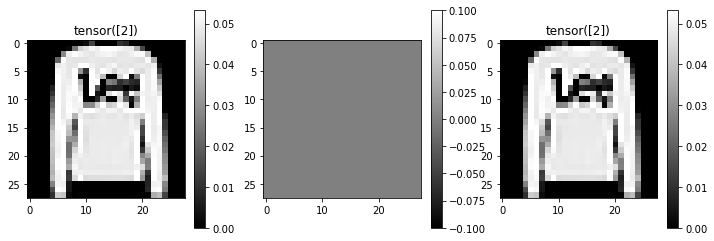

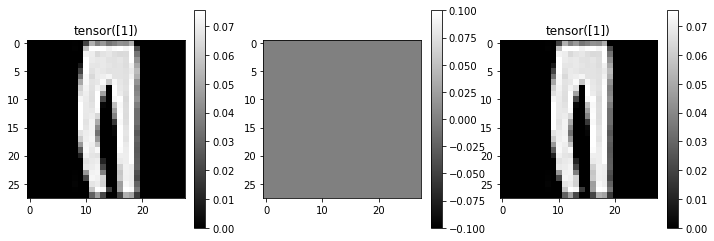

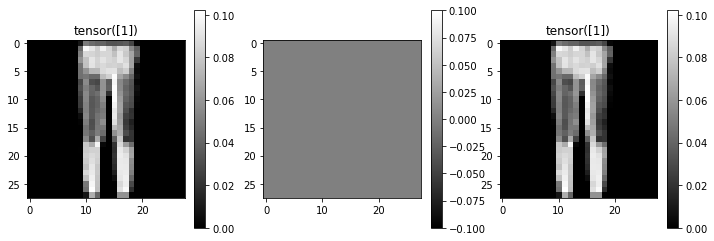

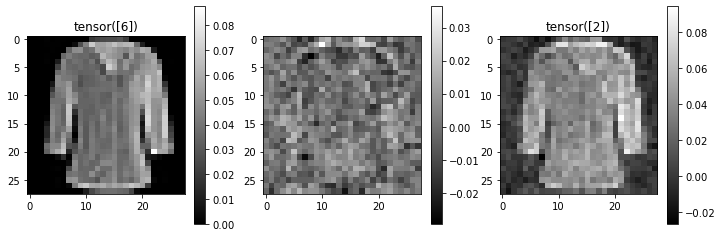

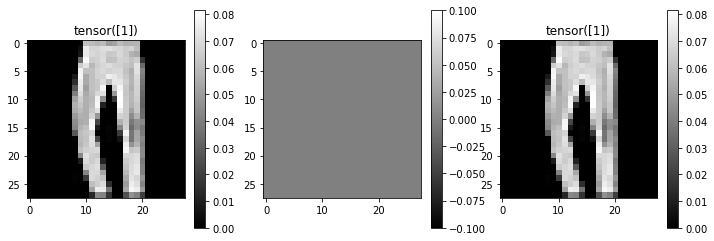

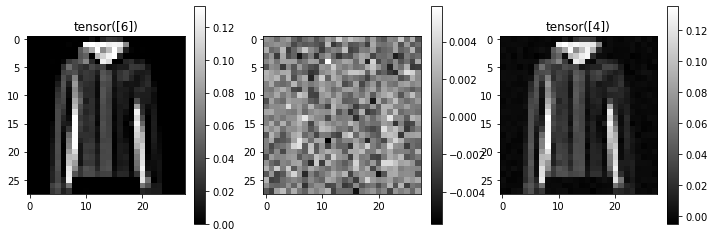

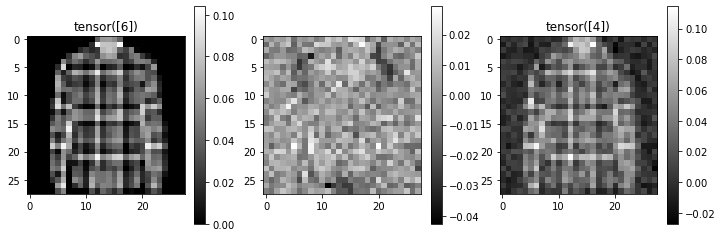

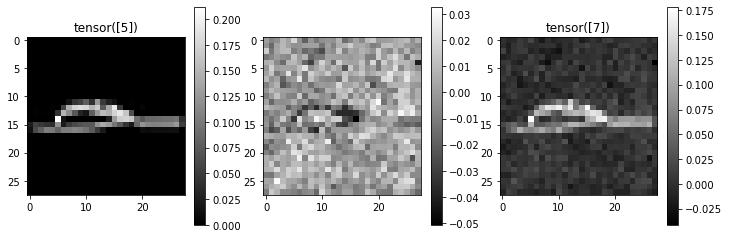

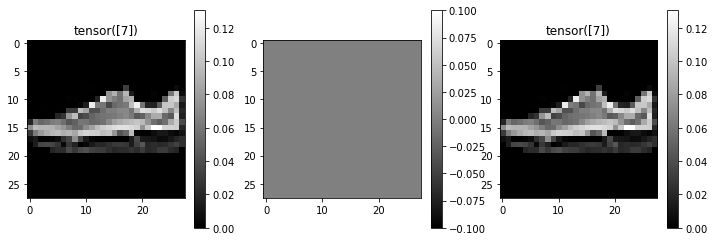

In [45]:
for i in range(10):

    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(model(x_test[i].reshape(1, 784)))
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(x_test_pert[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    plt.title(model(x_test_adv[i].reshape(1, 784)))
    plt.colorbar()
    
    plt.show()

In [46]:
df_sample = scaler.transform(x_test_adv.reshape(-1, 784))

In [47]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
yhat_attack = model(torch.tensor(df_sample).float())

acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
attack_test = (y_test == yhat_attack).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{attack_test = :6f}')

Validating...
acc = 0.833617
acc_test = 0.819600
attack_test = 0.727500


In [48]:
import pickle 

data = {'data':df_sample,
       'label':y_test}

with open('FMNIST_HD_DF.pickle', 'wb') as f:
    pickle.dump(data, f)